#### He2 PDFT Inversion - WuYang

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from CADMium import Pssolver, Psgrid, Partition, Inverter

Perform PDFT Calculation. 

Code should run as it is but for idential calculations increase to grid size to: [7,12,12]

In [17]:
a = 3.5
#Nuclear charge for fragments A and B
Za, Zb = 2,2
#Set polarization 1-Unpolarized, 2-Polarized
pol = 1
#Fragment a electrons [alpha, beta]
Nmo_a = [[1]] #Number of molecular orbitals to calculate
N_a   = [[2]]
#Ensemble mix
nu_a = 1
#Fragment b electrons
Nmo_b = [[1]]
N_b   = [[2]]
#Ensemble mix
nu_b = 1

#Molecular elctron configuration
Nmo_m = [[2]]
N_m   = [[4]]

#Set up grid
NP = 7
NM = [12,12]
L = np.arccosh(15/a)
loc = np.array(range(-4,5)) #Stencil outline

grid = Psgrid(NP, NM, a, L, loc)
grid.initialize()

part = Partition(grid, Za, Zb, pol, Nmo_a, N_a, nu_a, Nmo_b, N_b, nu_b, {
                                                                      "kinetic_part_type" : "inversion",
                                                                      "ab_sym" : True,
                                                                      "ens_spin_sym" : False,
                                                                        })

#Setup inverter object
mol_solver = Pssolver(grid, Nmo_m, N_m)
part.inverter = Inverter(grid, mol_solver, {"disp"         : True,
                                            "invert_type"  : "wuyang", 
                                            "ab_sym"       : True,
                                            "ens_spin_sym" : False})

#Make isolated calculation
part.optPartition.isolated = True
part.scf({"disp" : True})

#Save isolated densities
D0_frag_a = part.KSa.n.copy()
D0_frag_b = part.KSa.n.copy()

#Make pdft calculation
part.optPartition.isolated = False
part.scf({"disp"       : True,
          "alpha"      : [0.6],
          "max_iter"   : 200,
          "e_tol"      : 1e-9,
          "continuing" : True})


#Store full densities under the presence of vp.
Dvp_frag_a = part.KSa.n.copy()
Dvp_frag_b = part.KSb.n.copy()

                Total Energy ( a.u.)                               Inversion                

                __________________                ____________________________________     

Iteration         A              B                  iters      optimality        res       

___________________________________________________________________________________________ 

    1           -3.10770     -3.10770       1.000e+00 
    2           -2.78065     -2.78065       1.311e-01 
    3           -2.84459     -2.84459       2.499e-02 
    4           -2.83289     -2.83289       4.594e-03 
    5           -2.83476     -2.83476       7.331e-04 
    6           -2.83441     -2.83441       1.386e-04 
    7           -2.83446     -2.83446       2.161e-05 
    8           -2.83445     -2.83445       4.111e-06 
    9           -2.83446     -2.83446       6.506e-07 
   10           -2.83445     -2.83445       1.232e-07 
   11           -2.83445     -2.83445       1.957e-08 
                Total

---
Generate Figure 9. Parititon Potential. 

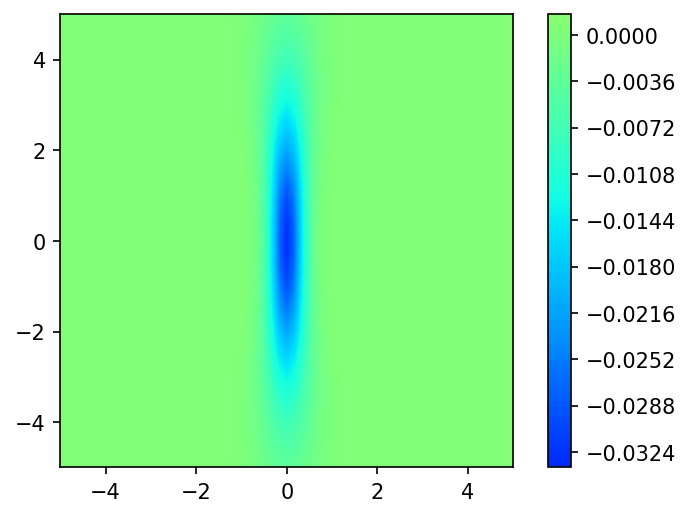

In [19]:
full, x,y = grid.plotter(part.V.vp[:,0])
fig, ax = plt.subplots(dpi=150)

plot = ax.contourf(x,y,full, levels=100, cmap="jet", vmin=-0.05, vmax=0.05)

ax.set_aspect('equal')
ax.set_xlim([-5,5])
ax.set_ylim([-5,5])

fig.colorbar(plot) 

---
Generate Figure 9. Difference between Fragment Density and Isolated Atomic Density. 

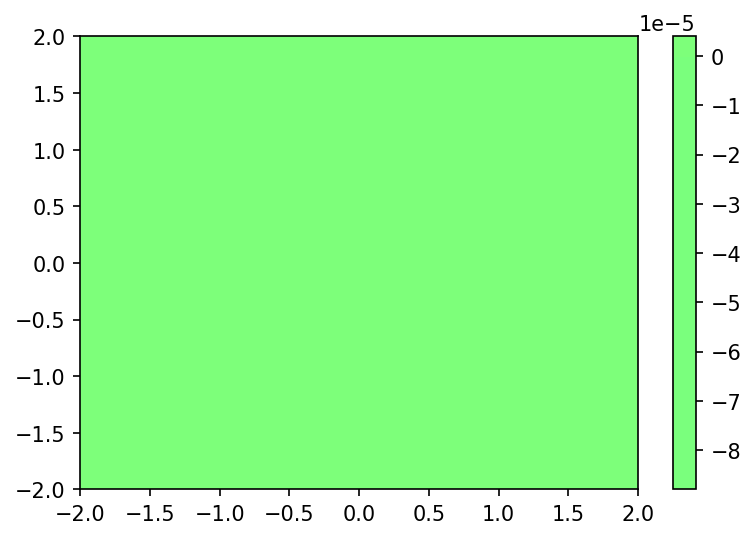

In [20]:
D_grid, x, y = grid.plotter(D0_frag_a[:,0])
D_vp_grid, _, _ = grid.plotter(Dvp_frag_a[:,0])

fig, ax = plt.subplots(dpi=150)

plot = ax.contourf(x,y, D_vp_grid - D_grid, levels=100, cmap="jet", vmin=-0.05, vmax=0.05)

ax.set_xlim([-2,2])
ax.set_ylim([-2,2])

fig.colorbar(plot)
# plt.show()

---
Generate Figure 11. Components of the Partition Potential

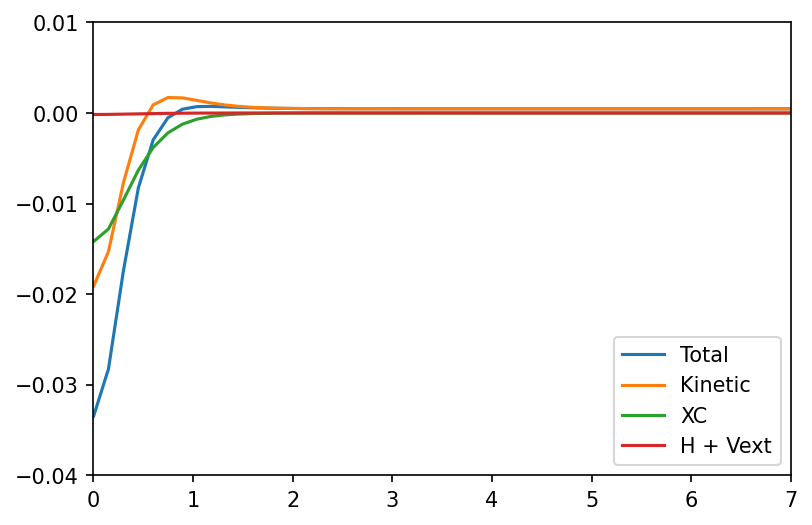

In [21]:
x_axis, vp      = grid.axis_plot(part.V.vp[:,0])
x_axis, vp_kin  = grid.axis_plot(part.V.vp_kin[:,0])
x_axis, vp_xc   = grid.axis_plot(part.V.vp_x[:,0] + part.V.vp_c[:,0] )
x_axis, vp_hext = grid.axis_plot( part.V.vp_h[:,0] + part.V.vp_pot[:,0])

fig, ax = plt.subplots(dpi=150)

ax.plot(x_axis, vp, label='Total')
ax.plot(x_axis, vp_kin, label='Kinetic')
ax.plot(x_axis, vp_xc, label='XC')
ax.plot(x_axis, vp_hext, label="H + Vext")

ax.set_xlim(0,7)
ax.set_ylim(-0.04, 0.01)

ax.legend()

---
Generate Table 9. Energies and Components of Ep, in atomic Units

In [22]:
values = {}
for i in part.E.__dict__:
    if i.startswith("__") is False:
        values.update({i : getattr(part.E, i)})
values

{'Ea': -2.834454719259801,
 'Eb': -2.834454719259801,
 'Ef': -5.668909438519602,
 'Tsf': 5.534566261725247,
 'Eksf': array([[-2.27933258]]),
 'Enucf': -13.249455410000271,
 'Exf': -1.723416970279257,
 'Ecf': -0.22215558251414871,
 'Ehf': 3.9915522625488284,
 'Vhxcf': 5.4337173462492805,
 'Ep': -0.5714524443701554,
 'Ep_pot': -1.1428814150973046,
 'Ep_kin': 3.941987072764164e-06,
 'Ep_hxc': 0.5714250287400764,
 'Et': -6.240361882889758,
 'Vnn': 0.5714285714285714,
 'E': -5.668933311461187,
 'evals_a': array([], dtype=float64),
 'evals_b': array([], dtype=float64),
 'Ep_h': 0.571452361315929,
 'Ep_x': -2.088050478343817e-05,
 'Ep_c': -6.452071069140697e-06}